## Paper name: "Human Level Control through deep Reinforcement Learning" 


In [0]:
import gym
from gym.wrappers import Monitor
import itertools
import numpy as np
import os
import random
import sys
import keras
import cv2
from skimage.color import rgb2gray
from collections import deque
from PIL import Image, ImageDraw
from skimage.transform import resize
import matplotlib.pyplot as plt

In [0]:
from keras.models import Sequential, Model
from keras.models import load_model, save_model
from keras.layers import Input, Add, Dense, Activation, Flatten, MaxPooling2D, ZeroPadding2D, AveragePooling2D, TimeDistributed
from keras.layers import Convolution2D as Conv2D
from keras.optimizers import Adam, RMSprop, SGD
import imageio
from skimage import img_as_ubyte
import keras.backend as K
import tensorflow as tf
from keras.layers import Lambda
from keras.layers import Input, Conv2D, Flatten, Dense, LeakyReLU, Multiply, Maximum, Add, merge


In [0]:
#ALL HYPERPARAMETERS
#Name of environment to be used
ENV_NAME = 'BreakoutDeterministic-v4'

#Size of replay memory
MEM_SIZE = 100000

#Gamma of Markov decision process
GAMMA = 0.99

#Exploration vs Exploitation
EPSILON = 1
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.9995
TOTAL_FRAMES = 5000000
EPSILON_MAX = 1

LEARNING_RATE = 0.0001
MOMENTUM = 0.001 
MINIBATCH_SIZE = 32

#Number of episodes to be trained on
NUM_EPISODES = 5000

#Frequence in which target network is to be updated
TGT_UPDATE_FREQ = 1000

#Name of directory in which GIFs will be stored 
VIS_DIR = "GIFs"

#Name of final model
MODEL_NAME = "model_dqn_breakout.h5"

#Numver of games to explore without Adjusting weights
NUM_EXPLORE = 1000

#Name of temporary model for updatng target network 
TMP_MODEL = 'tmp_model_1.h5'

#Maximum number of No operation actions taken at the beginning of the game
NOOPMAX = 10

#Number of evaluations for testing
NUM_EVAL = 20

In [0]:
#Lists to store loss and reward value per game! 
LOSS_HISTORY = []
REWARD_HISTORY = []
filepath= 1

#Frame Count
FCNT = 0
if not os.path.exists("models"): 
    os.mkdir("models")

In [0]:
class Replay_Memory:
    '''
    This replay memory clas would act as a buffer in which previous experiences would be stored. 
    It as experiences stored in format [ state, action, reward, next_state, done]
    '''
    def __init__(self, MEM_SIZE = 2000): 
        self.memory = deque(maxlen = MEM_SIZE)
        self.max_size = MEM_SIZE
    def add(self,  state, action, reward, next_state, done): 
        #print(len(self.memory))
        self.memory.append(( state, action, reward, next_state, done))

In [1]:
class Agent:
    '''
    This class would drive all the methods to be carried out by the agent. 
    '''
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.memory = Replay_Memory(MEM_SIZE)
        self.gamma = GAMMA
        self.epsilon = EPSILON
        self.epsilon_max = EPSILON_MAX
        self.epsilon_min = EPSILON_MIN
        self.total_frame = TOTAL_FRAMES
        self.slope = (self.epsilon_max - self.epsilon_min)/self.total_frame
        self.epsilon_decay = EPSILON_DECAY
        self.lr = LEARNING_RATE
        self.momentum = MOMENTUM
        self.dummy_input = np.zeros((1,self.action_size))
        self.dummy_batch = np.zeros((MINIBATCH_SIZE,self.action_size))
        self.model = self.build_model()
        #save_model(self.model, TMP_MODEL)
        self.target_model = self.get_tgt_model()
        print("Showing target model's layers")
        self.target_model.summary()
        
    def lambda_out_shape(self, input_shape):
        shape = list(input_shape)
        shape[-1] = 1
        return tuple(shape)
        
    def build_model(self):
        '''
        Model is built in this method
        '''
        input_frame = Input(shape=(84, 84, 4))
        action_one_hot = Input(shape=(self.action_size,))
        conv1 = Conv2D(32, (8, 8), strides=(4, 4), activation='relu')(input_frame)
        conv2 = Conv2D(64, (4, 4), strides=(2, 2), activation='relu')(conv1)
        conv3 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(conv2)
        flat_feature = Flatten()(conv3)
        hidden_feature = Dense(512)(flat_feature)
        lrelu_feature = LeakyReLU()(hidden_feature)
        q_value_prediction = Dense(self.action_size)(lrelu_feature)
        select_q_value_of_action = Multiply()([q_value_prediction,action_one_hot])
        target_q_value = Lambda(lambda x:K.sum(x, axis=-1, keepdims=True),output_shape=self.lambda_out_shape)(select_q_value_of_action)
        model = Model(inputs=[input_frame,action_one_hot], outputs=[q_value_prediction, target_q_value])
        model.compile(loss=['mse','mse'], loss_weights=[0.0,1.0],optimizer=Adam(self.lr))
        return model

    def get_tgt_model(self):
        '''
        This method would clone the architecture as well as the initial weights of the base model into target model        
        '''
        #self.target_model = load_model(TMP_MODEL, compile= False)

        #print("Clone Success? ")
        #print(np.array_equal(self.model.get_weights(), self.target_model.get_weights()))
        #for i in range(len(self.model.get_weights())):
        #    print(np.array_equal(self.model.get_weights()[i], self.target_model.get_weights()[i]))
        self.target_model = self.build_model()
        self.update_target_model()
        return self.target_model
        
    def update_target_model(self): 
        '''
        This method would update weights of target model
        '''
        #save_model(self.model, TMP_MODEL)
        #self.target_model = load_model(TMP_MODEL, compile= False)
        self.target_model.set_weights(self.model.get_weights())
        return
        #for i in range(len(self.model.get_weights())):
        #    print(np.array_equal(self.model.get_weights()[i], self.target_model.get_weights()[i]))
        
        #return

    def next_action(self, state):
        '''
        Get the next action using epsilon greedy policy for deciding whether to exploit or explore
        '''
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon_max - self.slope*(FCNT)
        #dummy_batch = np.zeros((self.,self.action_size))
        if (np.random.rand() <= self.epsilon):
            return env.action_space.sample()
        q_values = self.model.predict([np.expand_dims(state,axis=0),self.dummy_input])[0]
        #self.model.predict(np.expand_dims(state, axis=0))
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        '''
        Store the experience in our replay memory
        '''
        self.memory.add(state, action, reward, next_state, done)

    def replay(self, batch_size, filepath):
        '''
        Does the back propogation to adjust weights during exploitation action. 
        '''
        dummy_batch = np.zeros((batch_size,self.action_size))
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        terminal_batch = []
        y_batch = []

        # Sample random minibatch of transition from replay memory
        minibatch = random.sample(list(self.memory.memory), batch_size)
        dummy_batch = np.zeros((batch_size,self.action_size))
        for data in minibatch:
            state_batch.append(data[0])
            action_batch.append(data[1])
            reward_batch.append(data[2])
            next_state_batch.append(data[3])
            terminal_batch.append(data[4])
        
        terminal_batch = np.array(terminal_batch) + 0

        target_q_values_batch = self.target_model.predict([np.float32(np.array(next_state_batch)),self.dummy_batch])[0]
        y_batch = reward_batch + (1 - terminal_batch) * self.gamma * np.max(target_q_values_batch, axis=-1)
        
        a_one_hot = np.zeros((batch_size,self.action_size))
        for idx,ac in enumerate(action_batch):
            a_one_hot[idx,ac] = 1.0

        loss = self.model.train_on_batch([np.float32(np.array(state_batch)),a_one_hot],[self.dummy_batch,y_batch])
        
        LOSS_HISTORY.append(loss[1])
        
        #At target network's update frequency, update the target network
        if(filepath % TGT_UPDATE_FREQ == 0):
            self.update_target_model()
            print("Target model updated Successfully!")
            
        return 


In [0]:
def generate_gif(frame_no, frames, reward, path, e):
    '''
    Utility method to generate gif from frames
    '''
    for idx, frame_idx in enumerate(frames): 
        frames[idx] = resize(frame_idx, (420, 320, 3), 
                                     preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave(f'{path}{"episode_{0}_frame_{1}_reward_{2}.gif".format(e, frame_no, reward)}', 
                    frames, duration=1/100)


In [0]:
def preprocess(frame):
    '''
    This method resizes the frame to 84*84 and converts it to grayscale
    '''
    resized = cv2.resize(frame, (84, 84), interpolation = cv2.INTER_AREA)
    frame_gray = rgb2gray(resized)
    return frame_gray

In [11]:
env = gym.make(ENV_NAME)
agent = Agent(env)











Showing target model's layers
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 20, 20, 32)   8224        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 9, 9, 64)     32832       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_5[0][0]                   
____________________________________________________

In [2]:
#INITIAL EXPLORATION: 
'''
THIS IS DONE TO POPULATE REPLAY MEMORY WITH COMPLETE EXPLORATION TO INITIALIZE THE MEMORY 
'''
for e in range(NUM_EXPLORE):
    
    state = env.reset()
    #LAST LIVES = TOTAL NO OF LIVES REMAINING
    last_lives = 5
    
    #CHECKS IF ONE OF THE POSSIBLE LIVES IS LOST OR NOT
    terminal_life_lost = False 
    
    # FIRST ACTION IS ALWAYS 'FIRE' TO INITIATE THE GAME
    state, _, _, _ = env.step(1)
    for _ in range(random.randint(1, NOOPMAX)):
        #DOING RANDOM NO-OPs DURING START OF THE GAME TO STATE WITH A NEW STATE EVERY TIME
        state, _, _, _ = env.step(0)
    total_reward = 0
    processed_frame = preprocess(state)
    frames = []
    rgb_frames = []
    rgb_frames.append(state)

    for i in range(4): 
        frames.append(processed_frame)
        
    state = np.stack(frames[-4:], axis = 2)

    diff = 0
    for itr in range(20000):
        agent.epsilon = 1
        if(terminal_life_lost == True):
            state, _, _, _ = env.step(1)
            for _ in range(random.randint(1, 10)):
                state, _, _, _ = env.step(0)
            processed_frame = preprocess(state)
            frames = []
            for i in range(4):
                frames.append(processed_frame)
            state = np.stack(frames[-4:], axis = 2)

        action = env.action_space.sample()

        #execute action
        next_state, reward, done, info = env.step(action)
        
        if info['ale.lives'] < last_lives:
            terminal_life_lost = True
        else:
            terminal_life_lost = done
        last_lives = info['ale.lives']


        
        #REWARD CLIPPING IS DONE HERE
        if(reward > 0):
            reward = 1
        elif(reward < 0):
            reward = -1
        
        #total_reward = total_reward + reward
        processed_frame = preprocess(next_state)
        processed_frame = processed_frame.astype(np.uint8)
        frames = frames[-3:]
        frames.append(processed_frame)
        #print(processed_frame.shape)
        next_state = np.stack(frames[-4:], axis = 2)
        if(len(frames) != 4):
            print("issue!!")

        #Store experience in replay mem
        agent.store_experience(state, action, reward, next_state, terminal_life_lost)
        state = next_state
        
        if done: 
            if(e % 100 == 0):
                print("Finished exploring for {} episodes".format(e))
            break
print("EXPLORATION STEP COMPLETED")

NameError: name 'NUM_EXPLORE' is not defined



e =  10  eps =  0.99737254  This reward =  1.0  Frame_cnt =  1328
e =  20  eps =  0.99480052  This reward =  0.0  Frame_cnt =  2627
Finished episode  25 / 5000  Total reward =  0.88
e =  30  eps =  0.99215722  This reward =  2.0  Frame_cnt =  3962
e =  40  eps =  0.9894466  This reward =  2.0  Frame_cnt =  5331
Finished episode  50 / 5000  Total reward =  1.52
e =  50  eps =  0.98644888  This reward =  1.0  Frame_cnt =  6845
e =  60  eps =  0.98407486  This reward =  1.0  Frame_cnt =  8044
e =  70  eps =  0.98185528  This reward =  0.0  Frame_cnt =  9165
Finished episode  75 / 5000  Total reward =  0.72
e =  80  eps =  0.97908724  This reward =  1.0  Frame_cnt =  10563
e =  90  eps =  0.97657462  This reward =  2.0  Frame_cnt =  11832
Finished episode  100 / 5000  Total reward =  1.2
e =  100  eps =  0.9739154800000001  This reward =  1.0  Frame_cnt =  13175
e =  110  eps =  0.97171372  This reward =  1.0  Frame_cnt =  14287
e =  120  eps =  0.96919714  This reward =  0.0  Frame_cnt 

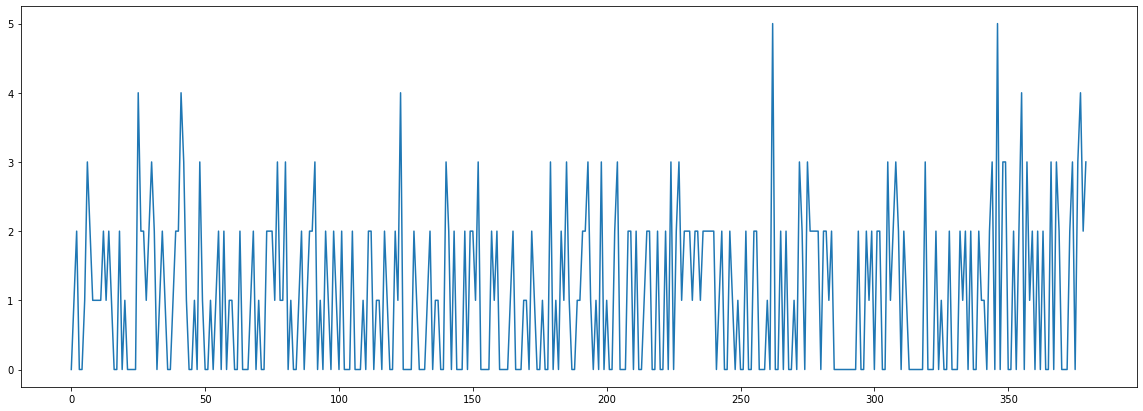

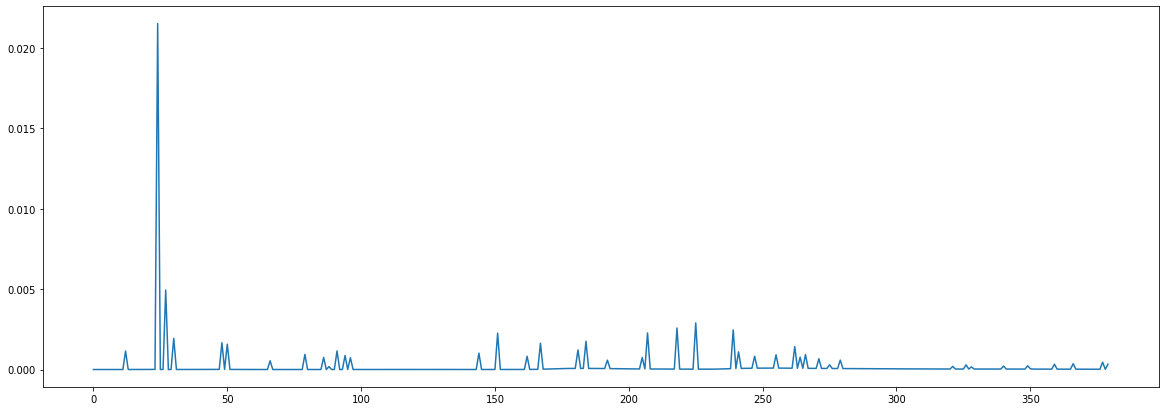

e =  390  eps =  0.89857846  This reward =  0.0  Frame_cnt =  51224
Finished episode  400 / 5000  Total reward =  1.2
e =  400  eps =  0.8959312  This reward =  0.0  Frame_cnt =  52561
e =  410  eps =  0.89381458  This reward =  0.0  Frame_cnt =  53630
e =  420  eps =  0.89095942  This reward =  2.0  Frame_cnt =  55072
Finished episode  425 / 5000  Total reward =  1.0
e =  430  eps =  0.88798546  This reward =  3.0  Frame_cnt =  56574
e =  440  eps =  0.88578964  This reward =  1.0  Frame_cnt =  57683
Finished episode  450 / 5000  Total reward =  1.0
e =  450  eps =  0.88277608  This reward =  0.0  Frame_cnt =  59205
e =  460  eps =  0.88022386  This reward =  0.0  Frame_cnt =  60494
e =  470  eps =  0.87771718  This reward =  2.0  Frame_cnt =  61760
Finished episode  475 / 5000  Total reward =  0.96
e =  480  eps =  0.87537484  This reward =  0.0  Frame_cnt =  62943
e =  490  eps =  0.87314734  This reward =  2.0  Frame_cnt =  64068
Finished episode  500 / 5000  Total reward =  0.76
e

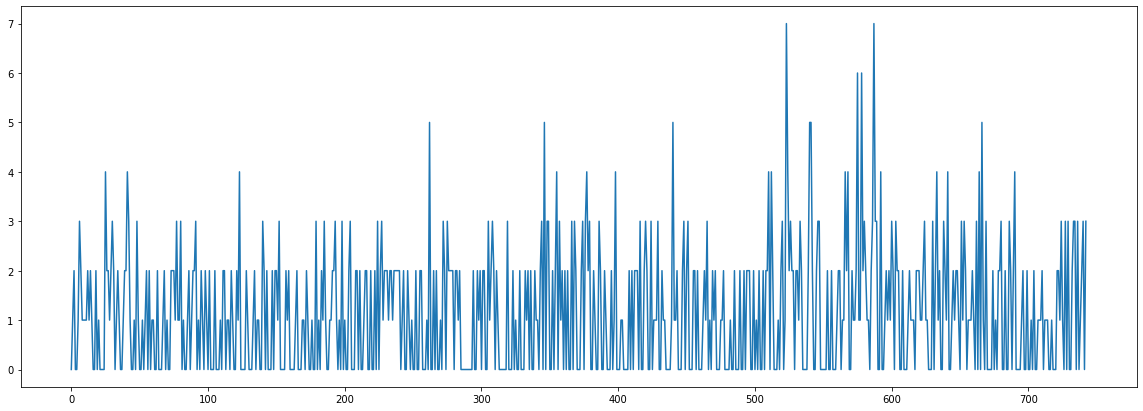

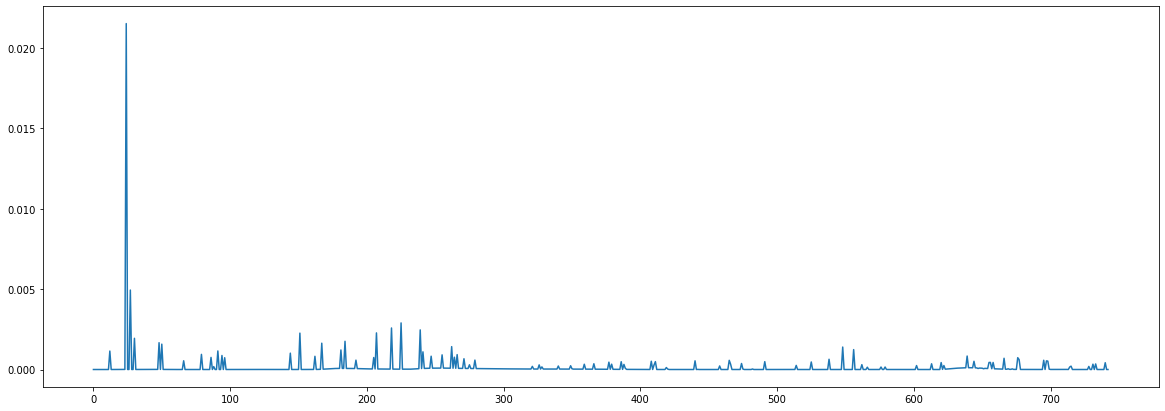

Finished episode  750 / 5000  Total reward =  1.68
e =  750  eps =  0.80002396  This reward =  1.0  Frame_cnt =  100999
e =  760  eps =  0.79671538  This reward =  1.0  Frame_cnt =  102670
e =  770  eps =  0.79427998  This reward =  0.0  Frame_cnt =  103900
Finished episode  775 / 5000  Total reward =  1.28
e =  780  eps =  0.7915852  This reward =  0.0  Frame_cnt =  105261
e =  790  eps =  0.78919534  This reward =  3.0  Frame_cnt =  106468
Finished episode  800 / 5000  Total reward =  1.04
e =  800  eps =  0.7866629199999999  This reward =  2.0  Frame_cnt =  107747
e =  810  eps =  0.7839978400000001  This reward =  2.0  Frame_cnt =  109093
e =  820  eps =  0.7817545  This reward =  2.0  Frame_cnt =  110226
Finished episode  825 / 5000  Total reward =  1.0
e =  830  eps =  0.7780914999999999  This reward =  4.0  Frame_cnt =  112076
e =  840  eps =  0.7751155599999999  This reward =  1.0  Frame_cnt =  113579
Finished episode  850 / 5000  Total reward =  2.88
e =  850  eps =  0.7708348

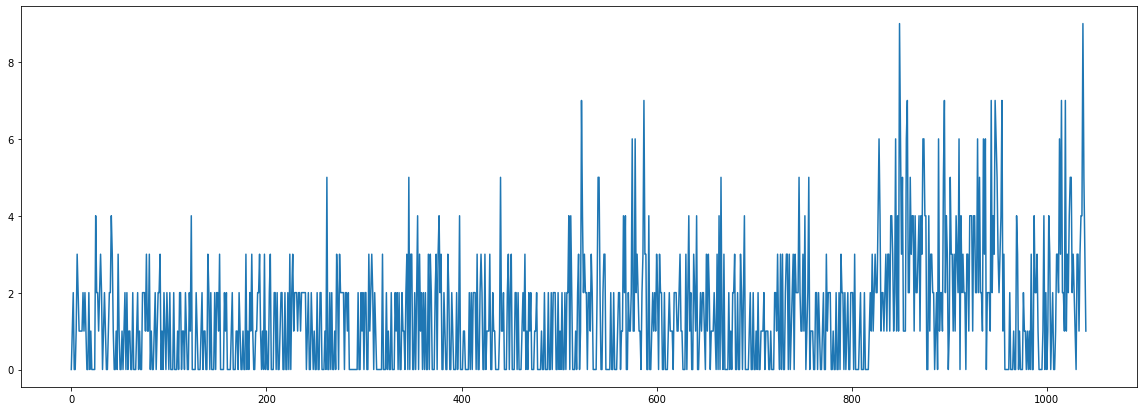

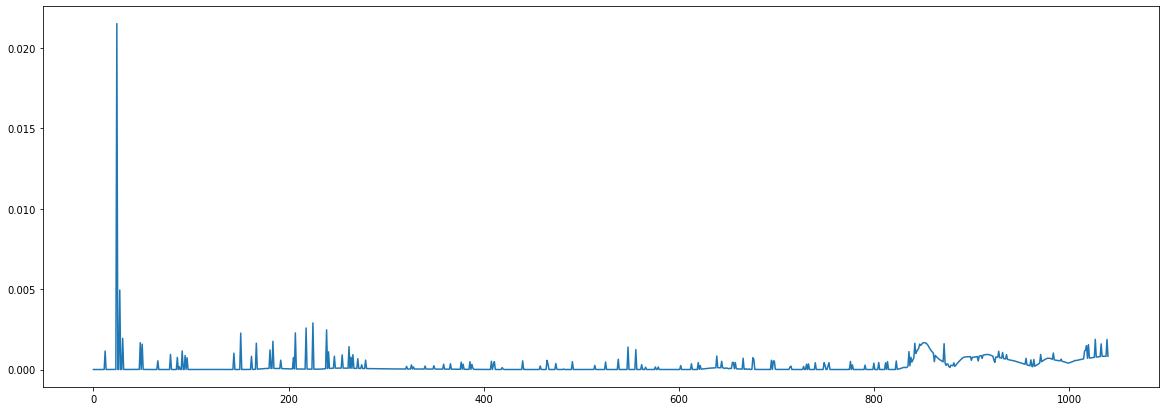

Finished episode  1050 / 5000  Total reward =  3.2
e =  1050  eps =  0.69952114  This reward =  2.0  Frame_cnt =  151758
e =  1060  eps =  0.69740452  This reward =  2.0  Frame_cnt =  152827
e =  1070  eps =  0.69445828  This reward =  3.0  Frame_cnt =  154315
Finished episode  1075 / 5000  Total reward =  0.76
e =  1080  eps =  0.69198328  This reward =  2.0  Frame_cnt =  155565
e =  1090  eps =  0.6894865  This reward =  0.0  Frame_cnt =  156826
Finished episode  1100 / 5000  Total reward =  0.88
e =  1100  eps =  0.68723722  This reward =  0.0  Frame_cnt =  157962
e =  1110  eps =  0.6847087599999999  This reward =  0.0  Frame_cnt =  159239
e =  1120  eps =  0.68233078  This reward =  1.0  Frame_cnt =  160440
Finished episode  1125 / 5000  Total reward =  0.96
e =  1130  eps =  0.67949344  This reward =  3.0  Frame_cnt =  161873
e =  1140  eps =  0.6762739600000001  This reward =  1.0  Frame_cnt =  163499
Finished episode  1150 / 5000  Total reward =  1.6
e =  1150  eps =  0.6734742

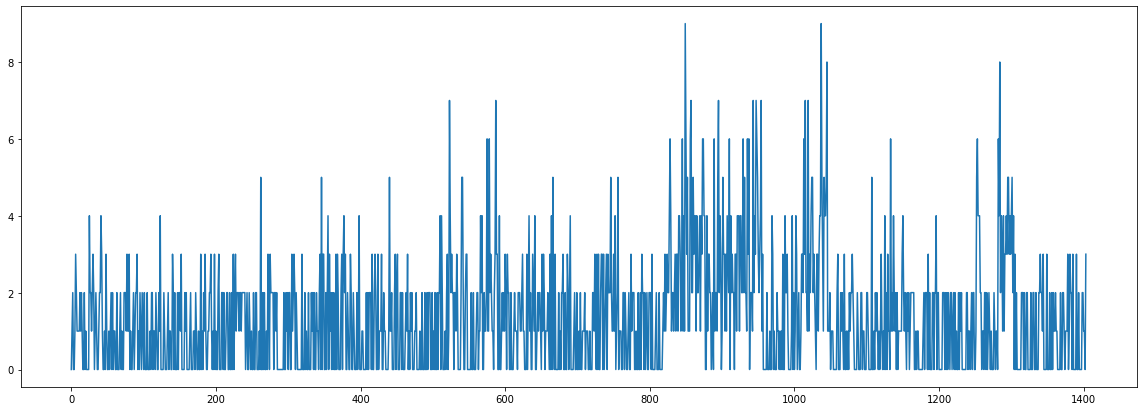

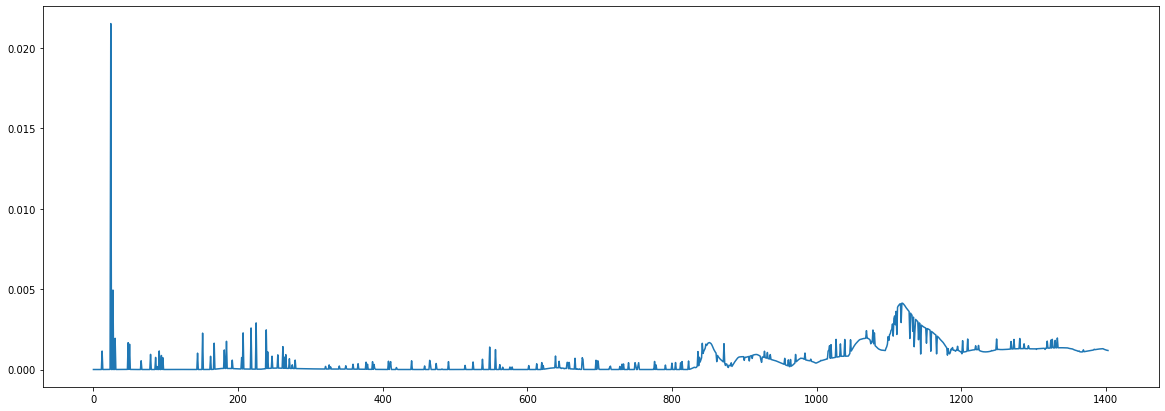

e =  1410  eps =  0.6025347999999999  This reward =  0.0  Frame_cnt =  200741
e =  1420  eps =  0.59745808  This reward =  9.0  Frame_cnt =  203305
Finished episode  1425 / 5000  Total reward =  2.64
e =  1430  eps =  0.59440888  This reward =  2.0  Frame_cnt =  204845
e =  1440  eps =  0.59161312  This reward =  0.0  Frame_cnt =  206257
Finished episode  1450 / 5000  Total reward =  1.16
e =  1450  eps =  0.5893202799999999  This reward =  1.0  Frame_cnt =  207415
e =  1460  eps =  0.58425346  This reward =  4.0  Frame_cnt =  209974
e =  1470  eps =  0.57892528  This reward =  8.0  Frame_cnt =  212665
Finished episode  1475 / 5000  Total reward =  4.92
e =  1480  eps =  0.5745277  This reward =  3.0  Frame_cnt =  214886
e =  1490  eps =  0.5694984999999999  This reward =  6.0  Frame_cnt =  217426
Finished episode  1500 / 5000  Total reward =  4.44
e =  1500  eps =  0.5645267199999999  This reward =  3.0  Frame_cnt =  219937
e =  1510  eps =  0.560638  This reward =  3.0  Frame_cnt =  

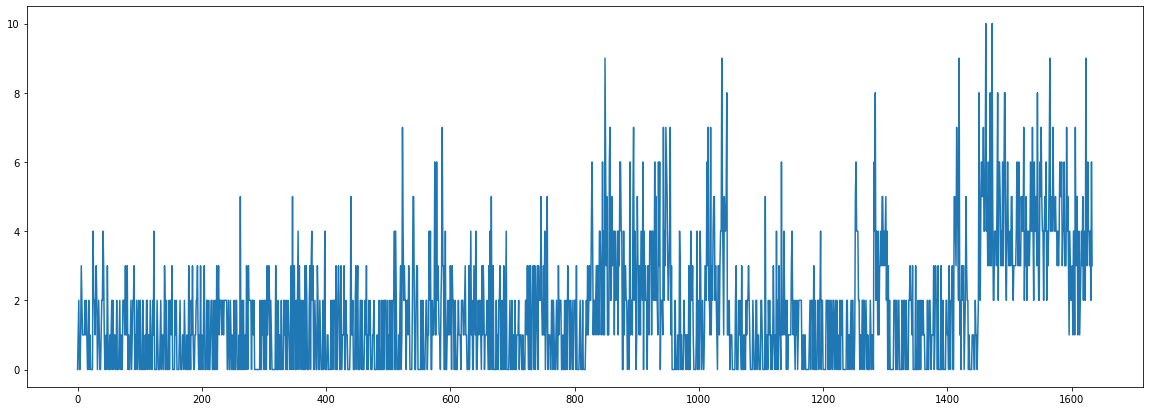

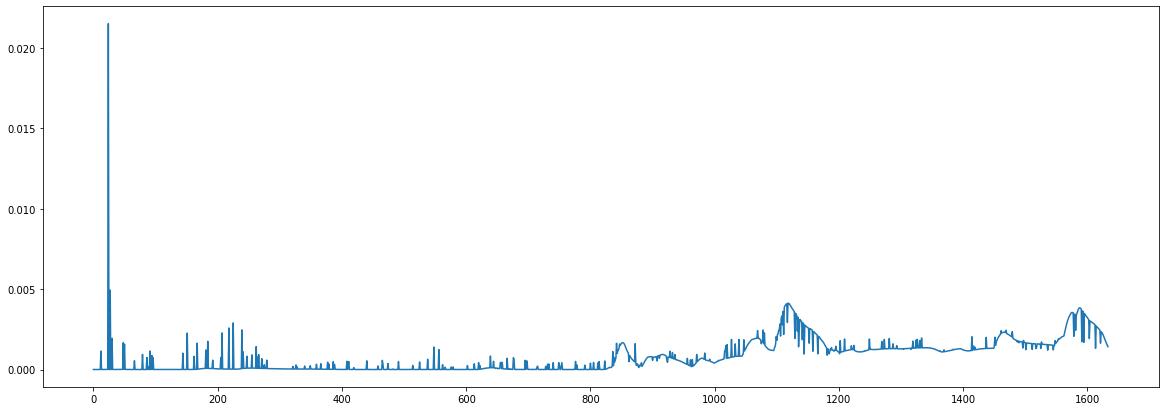

e =  1640  eps =  0.50367736  This reward =  1.0  Frame_cnt =  250669
Finished episode  1650 / 5000  Total reward =  2.04
e =  1650  eps =  0.50112712  This reward =  3.0  Frame_cnt =  251957
e =  1660  eps =  0.4986838  This reward =  2.0  Frame_cnt =  253191
e =  1670  eps =  0.49320118  This reward =  5.0  Frame_cnt =  255960
Finished episode  1675 / 5000  Total reward =  3.44
e =  1680  eps =  0.48833631999999993  This reward =  4.0  Frame_cnt =  258417
e =  1690  eps =  0.48362392  This reward =  4.0  Frame_cnt =  260797
Finished episode  1700 / 5000  Total reward =  4.84
e =  1700  eps =  0.47847987999999997  This reward =  6.0  Frame_cnt =  263395
e =  1710  eps =  0.47415951999999995  This reward =  2.0  Frame_cnt =  265577
e =  1720  eps =  0.47124298  This reward =  6.0  Frame_cnt =  267050
Finished episode  1725 / 5000  Total reward =  3.16
e =  1730  eps =  0.46569105999999993  This reward =  8.0  Frame_cnt =  269854
e =  1740  eps =  0.46124002  This reward =  0.0  Frame_c

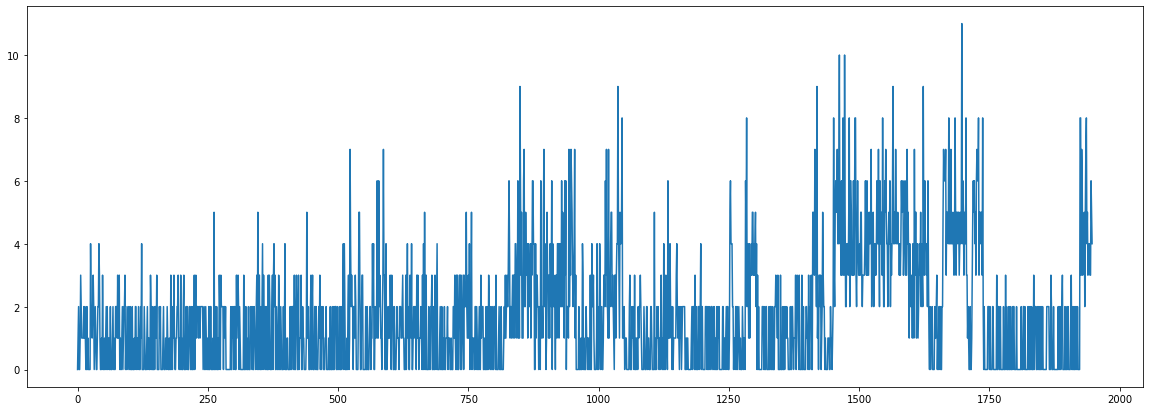

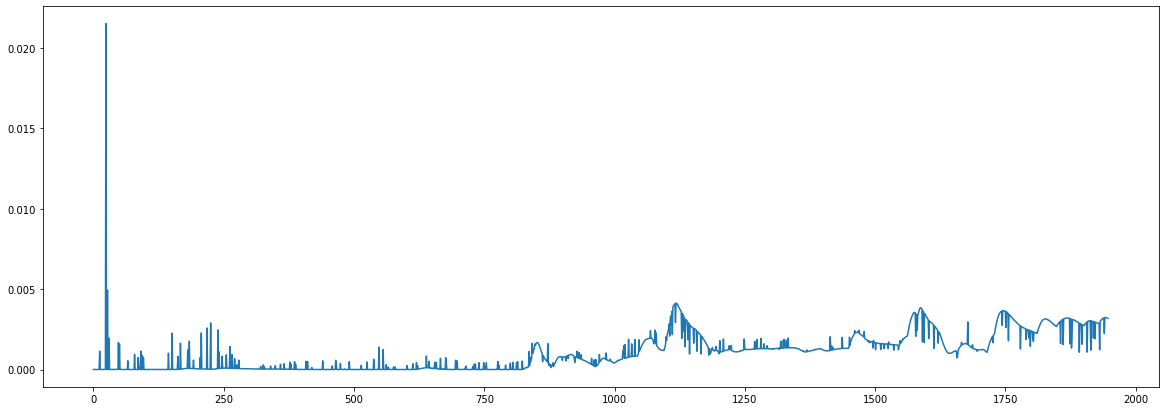

Finished episode  1950 / 5000  Total reward =  4.72
e =  1950  eps =  0.40514463999999994  This reward =  5.0  Frame_cnt =  300433
e =  1960  eps =  0.4003847199999999  This reward =  4.0  Frame_cnt =  302837
e =  1970  eps =  0.39545847999999995  This reward =  3.0  Frame_cnt =  305325
Finished episode  1975 / 5000  Total reward =  4.08
e =  1980  eps =  0.39268647999999995  This reward =  1.0  Frame_cnt =  306725
e =  1990  eps =  0.3902392  This reward =  2.0  Frame_cnt =  307961
Finished episode  2000 / 5000  Total reward =  0.84
Target model updated Successfully!
e =  2000  eps =  0.38805526  This reward =  0.0  Frame_cnt =  309064
e =  2010  eps =  0.38551492  This reward =  0.0  Frame_cnt =  310347
e =  2020  eps =  0.3823211799999999  This reward =  2.0  Frame_cnt =  311960
Finished episode  2025 / 5000  Total reward =  2.4
e =  2030  eps =  0.37660293999999994  This reward =  3.0  Frame_cnt =  314848
e =  2040  eps =  0.37172224  This reward =  8.0  Frame_cnt =  317313
Finishe

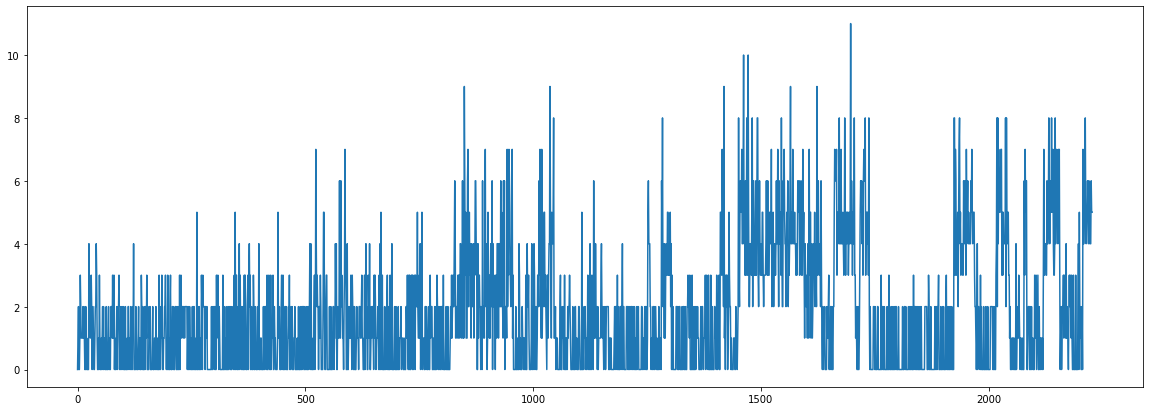

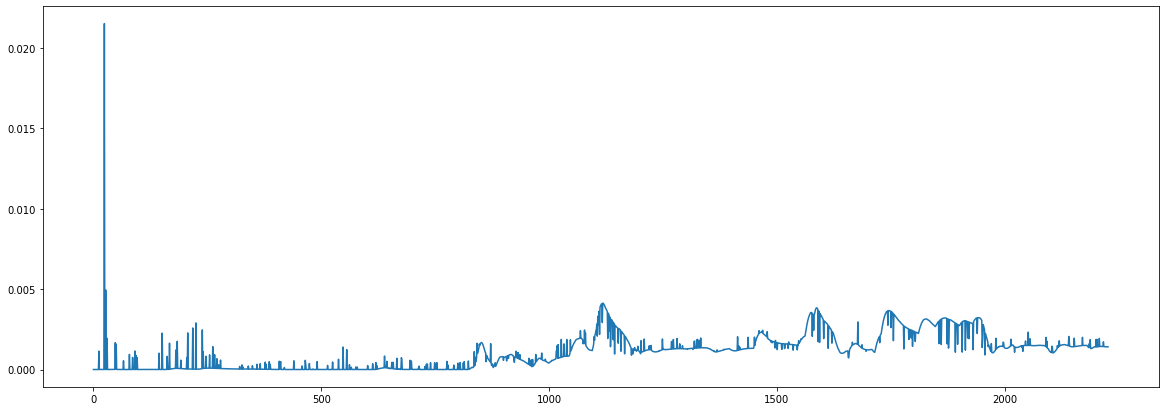

e =  2230  eps =  0.30609513999999993  This reward =  6.0  Frame_cnt =  350458
e =  2240  eps =  0.30070756  This reward =  1.0  Frame_cnt =  353179
Finished episode  2250 / 5000  Total reward =  3.64
e =  2250  eps =  0.2982404799999999  This reward =  2.0  Frame_cnt =  354425
e =  2260  eps =  0.2957912199999999  This reward =  2.0  Frame_cnt =  355662
e =  2270  eps =  0.29337561999999995  This reward =  2.0  Frame_cnt =  356882
Finished episode  2275 / 5000  Total reward =  0.76
e =  2280  eps =  0.2912194  This reward =  0.0  Frame_cnt =  357971
e =  2290  eps =  0.28873054  This reward =  2.0  Frame_cnt =  359228
Finished episode  2300 / 5000  Total reward =  2.28
e =  2300  eps =  0.2840537799999999  This reward =  4.0  Frame_cnt =  361590
e =  2310  eps =  0.27973936  This reward =  8.0  Frame_cnt =  363769
e =  2320  eps =  0.27472204  This reward =  6.0  Frame_cnt =  366303
Finished episode  2325 / 5000  Total reward =  4.64
e =  2330  eps =  0.26986113999999994  This reward 

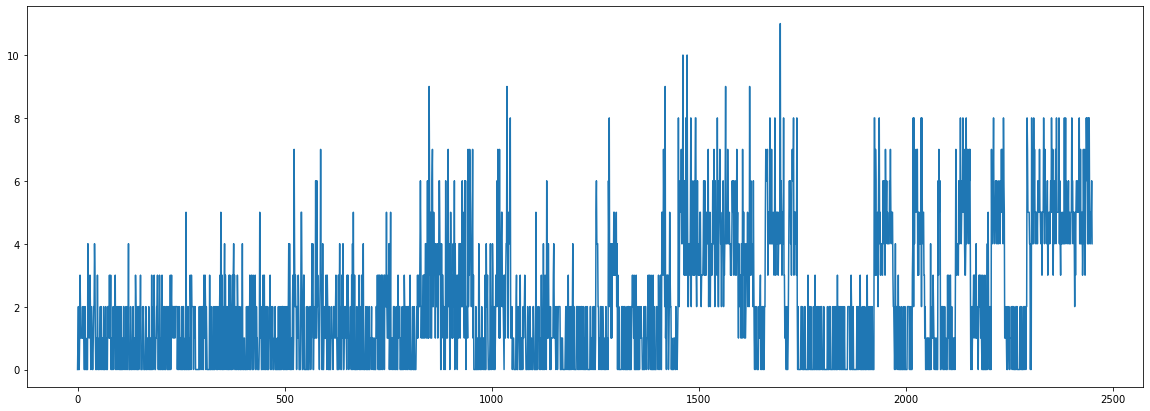

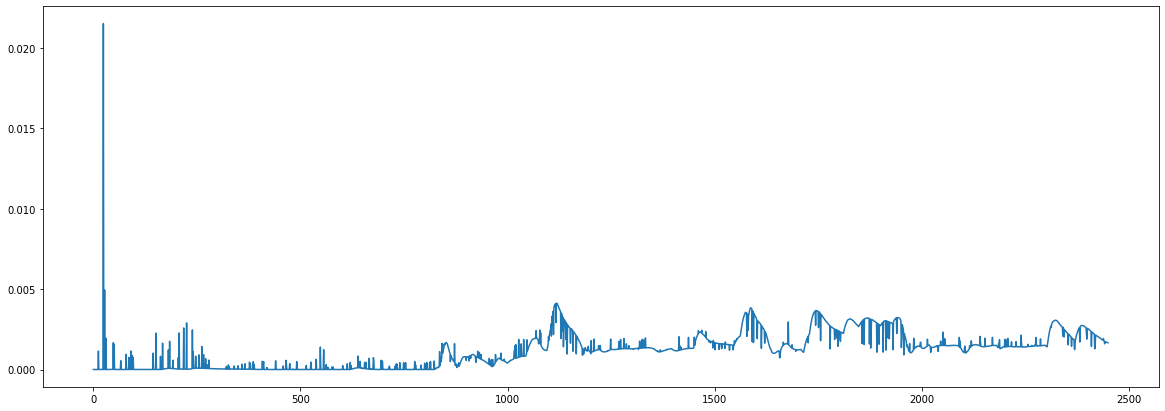

e =  2460  eps =  0.20434293999999997  This reward =  3.0  Frame_cnt =  401848
e =  2470  eps =  0.19929394  This reward =  4.0  Frame_cnt =  404398
Finished episode  2475 / 5000  Total reward =  4.8
e =  2480  eps =  0.19458747999999992  This reward =  4.0  Frame_cnt =  406775
e =  2490  eps =  0.18952857999999995  This reward =  4.0  Frame_cnt =  409330
Finished episode  2500 / 5000  Total reward =  4.84
e =  2500  eps =  0.18473896  This reward =  5.0  Frame_cnt =  411749
e =  2510  eps =  0.1799770599999999  This reward =  2.0  Frame_cnt =  414154
e =  2520  eps =  0.17505675999999992  This reward =  5.0  Frame_cnt =  416639
Finished episode  2525 / 5000  Total reward =  5.0
e =  2530  eps =  0.1704750399999999  This reward =  5.0  Frame_cnt =  418953
e =  2540  eps =  0.16545177999999994  This reward =  5.0  Frame_cnt =  421490
Finished episode  2550 / 5000  Total reward =  4.76
e =  2550  eps =  0.16103044  This reward =  5.0  Frame_cnt =  423723
e =  2560  eps =  0.1559636199999

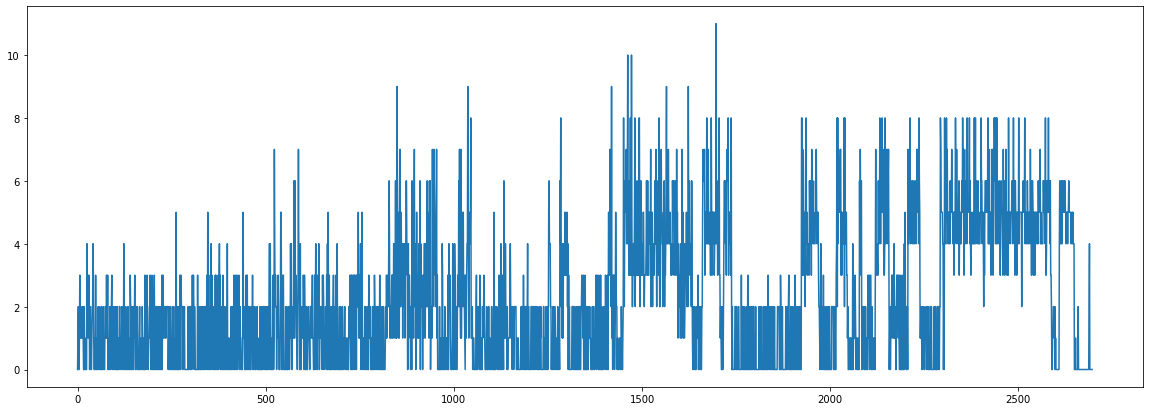

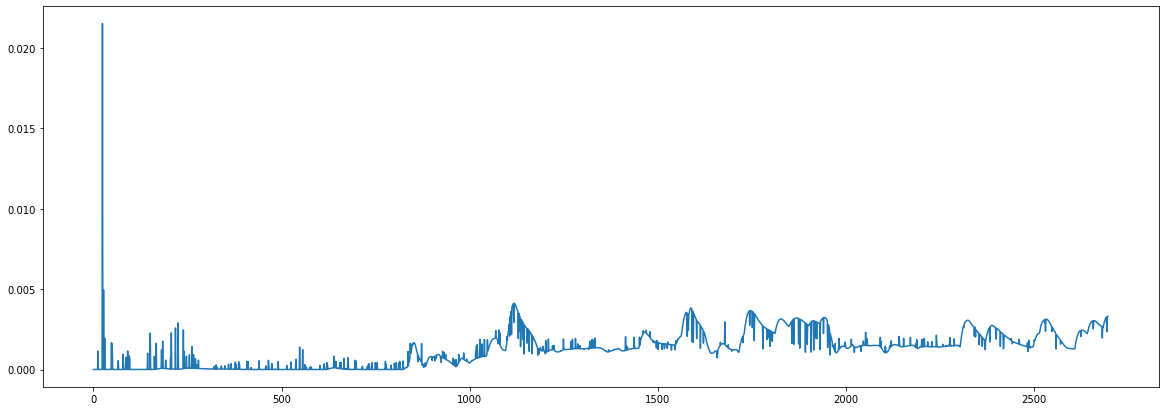

Finished episode  2700 / 5000  Total reward =  0.24
e =  2700  eps =  0.10851093999999994  This reward =  0.0  Frame_cnt =  450248
e =  2710  eps =  0.10654083999999997  This reward =  0.0  Frame_cnt =  451243
e =  2720  eps =  0.10469745999999991  This reward =  0.0  Frame_cnt =  452174
Finished episode  2725 / 5000  Total reward =  0.08
e =  2730  eps =  0.10290358  This reward =  0.0  Frame_cnt =  453080
e =  2740  eps =  0.10080873999999995  This reward =  2.0  Frame_cnt =  454138
Finished episode  2750 / 5000  Total reward =  1.96
e =  2750  eps =  0.09620721999999993  This reward =  5.0  Frame_cnt =  456462
e =  2760  eps =  0.09136809999999995  This reward =  6.0  Frame_cnt =  458906
e =  2770  eps =  0.08655471999999997  This reward =  5.0  Frame_cnt =  461337
Finished episode  2775 / 5000  Total reward =  5.16
e =  2780  eps =  0.0818324199999999  This reward =  5.0  Frame_cnt =  463722
e =  2790  eps =  0.07718139999999996  This reward =  5.0  Frame_cnt =  466071
Finished epi

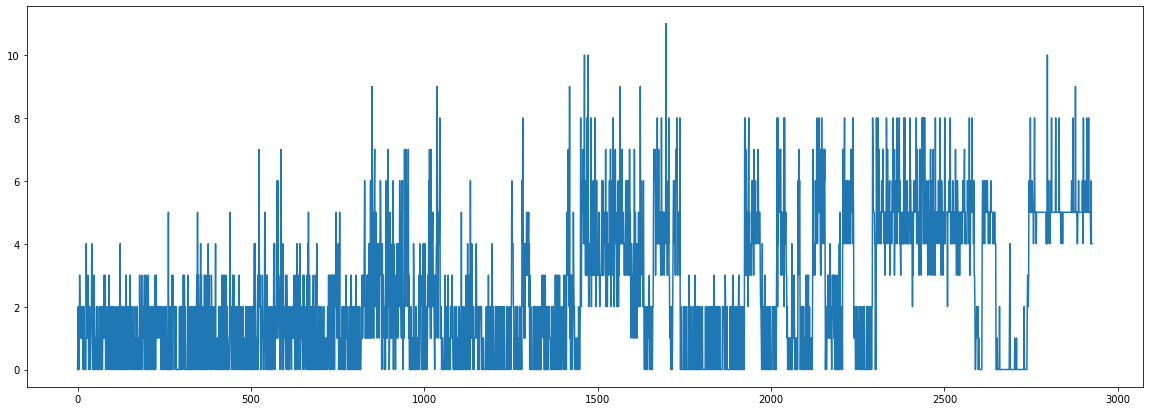

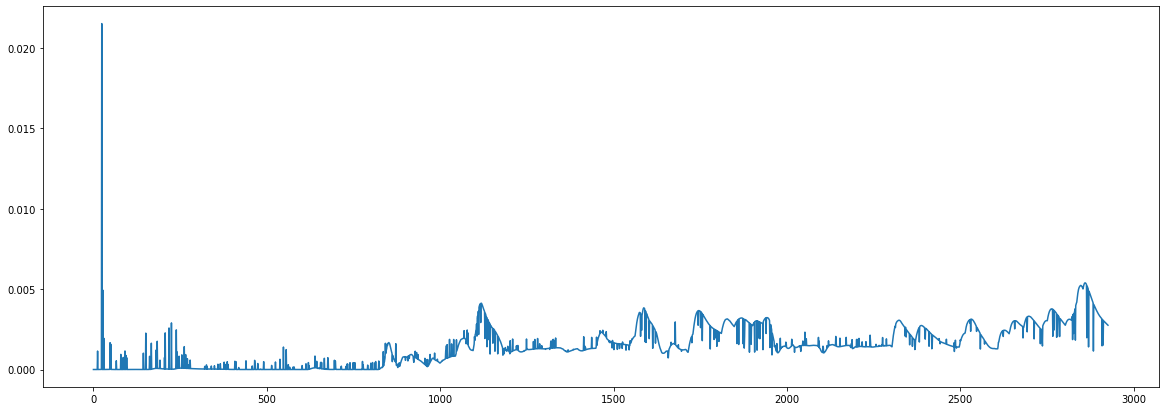

e =  2930  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  500669
e =  2940  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  503035
Finished episode  2950 / 5000  Total reward =  4.92
e =  2950  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  505618
e =  2960  eps =  0.009999999999999898  This reward =  4.0  Frame_cnt =  507929
e =  2970  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  510436
Finished episode  2975 / 5000  Total reward =  4.88
e =  2980  eps =  0.009999999999999898  This reward =  4.0  Frame_cnt =  512773
e =  2990  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  515064
Finished episode  3000 / 5000  Total reward =  5.08
Target model updated Successfully!
e =  3000  eps =  0.009999999999999898  This reward =  4.0  Frame_cnt =  517819
e =  3010  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  520286
e =  3020  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  522769
Finished 

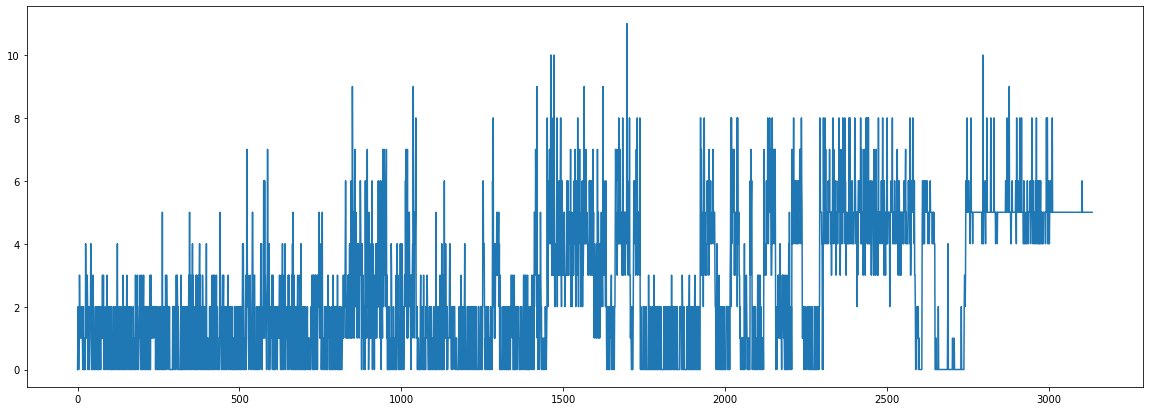

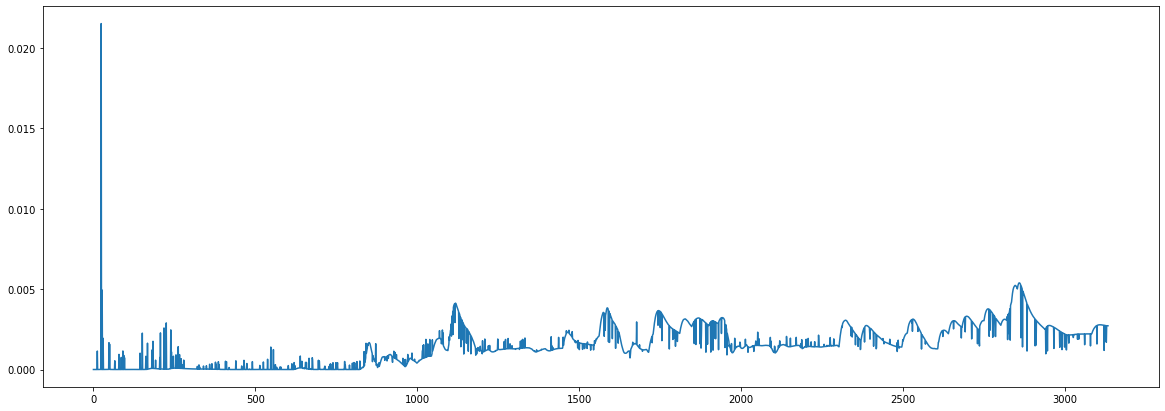

e =  3140  eps =  0.009999999999999898  This reward =  6.0  Frame_cnt =  551100
Finished episode  3150 / 5000  Total reward =  5.0
e =  3150  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  553420
e =  3160  eps =  0.009999999999999898  This reward =  9.0  Frame_cnt =  556206
e =  3170  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  558788
Finished episode  3175 / 5000  Total reward =  5.48
e =  3180  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  561184
e =  3190  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  563523
Finished episode  3200 / 5000  Total reward =  5.04
e =  3200  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  565892
e =  3210  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  568538
e =  3220  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  571287
Finished episode  3225 / 5000  Total reward =  5.6
e =  3230  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  5

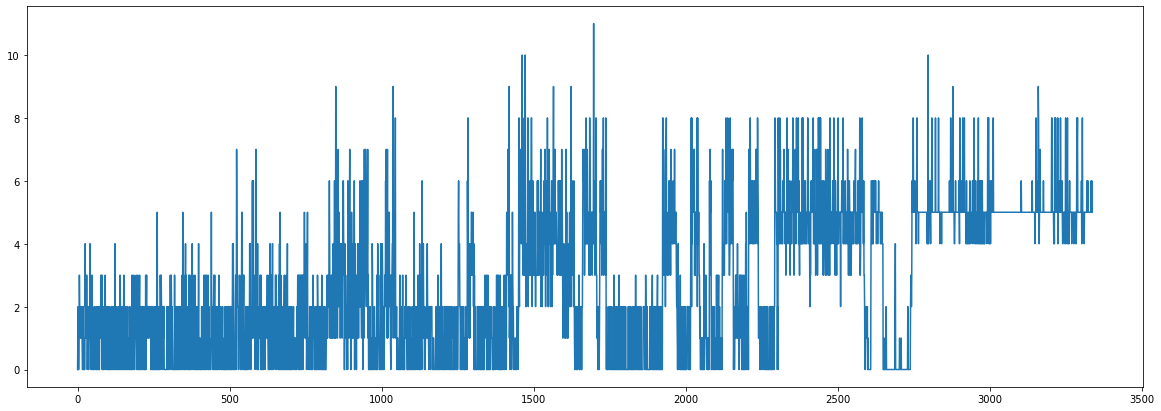

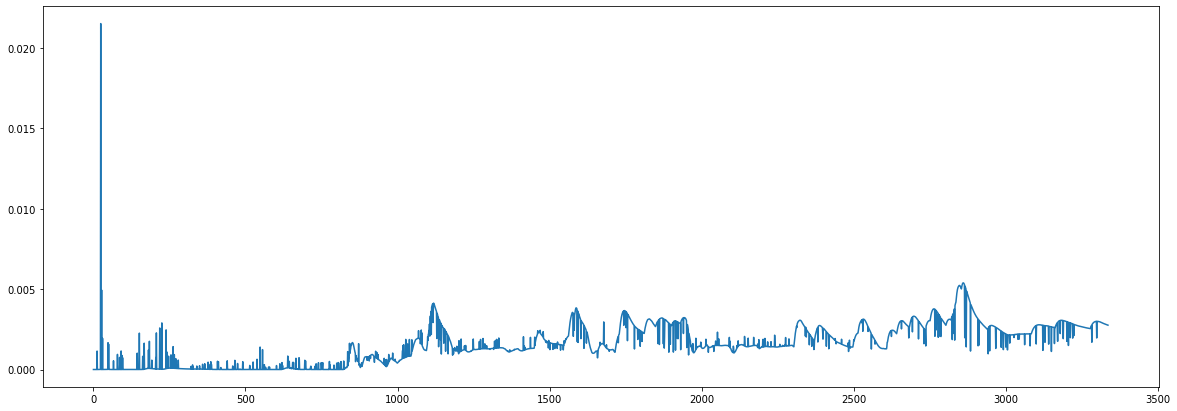

e =  3340  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  600695
Finished episode  3350 / 5000  Total reward =  5.2
e =  3350  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  603199
e =  3360  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  605579
e =  3370  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  607959
Finished episode  3375 / 5000  Total reward =  4.96
e =  3380  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  610455
e =  3390  eps =  0.009999999999999898  This reward =  8.0  Frame_cnt =  612937
Finished episode  3400 / 5000  Total reward =  5.36
e =  3400  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  615488
e =  3410  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  617993
e =  3420  eps =  0.009999999999999898  This reward =  8.0  Frame_cnt =  620443
Finished episode  3425 / 5000  Total reward =  5.2
e =  3430  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  6

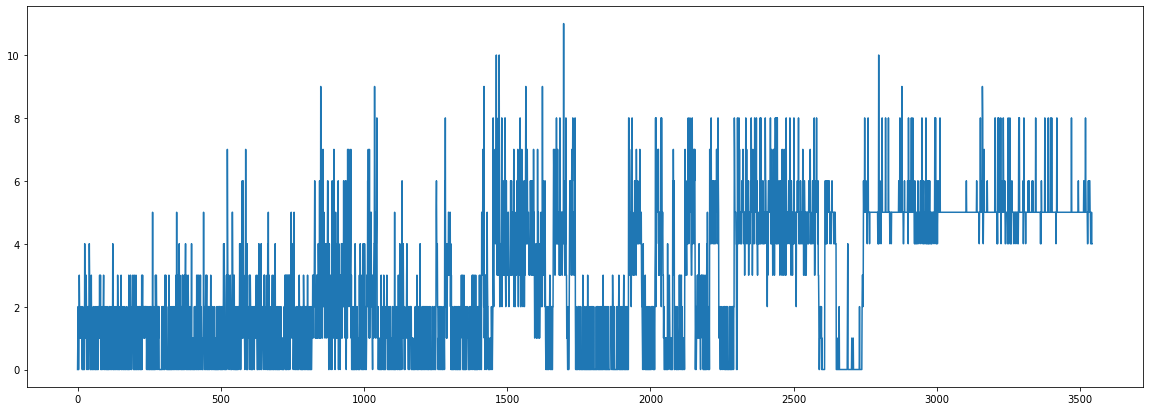

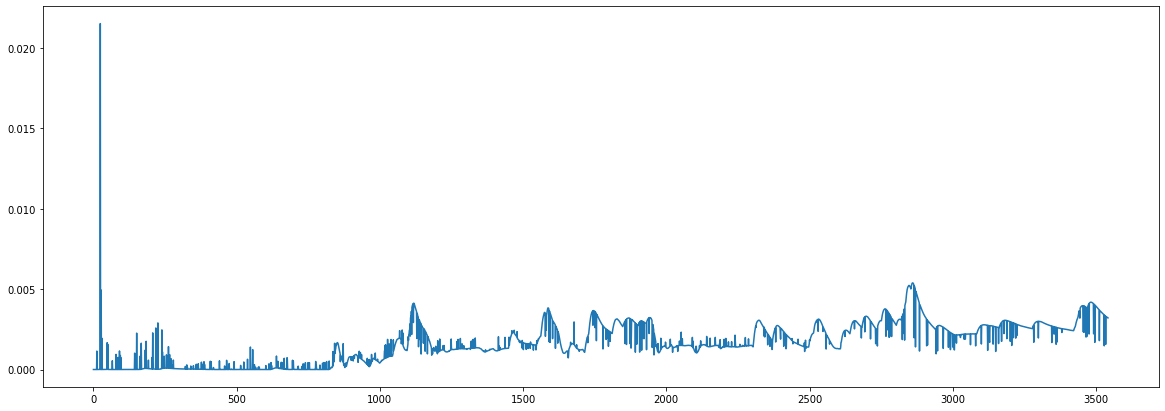

Finished episode  3550 / 5000  Total reward =  5.12
e =  3550  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  651792
e =  3560  eps =  0.009999999999999898  This reward =  6.0  Frame_cnt =  654485
e =  3570  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  656832
Finished episode  3575 / 5000  Total reward =  5.16
e =  3580  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  659327
e =  3590  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  661797
Finished episode  3600 / 5000  Total reward =  5.24
e =  3600  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  664109
e =  3610  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  666601
e =  3620  eps =  0.009999999999999898  This reward =  6.0  Frame_cnt =  669264
Finished episode  3625 / 5000  Total reward =  5.48
e =  3630  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  671911
e =  3640  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt = 

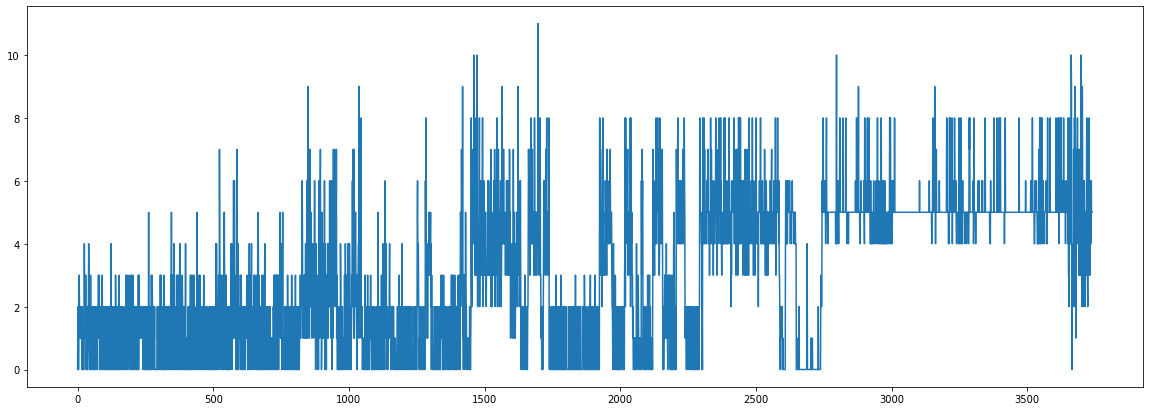

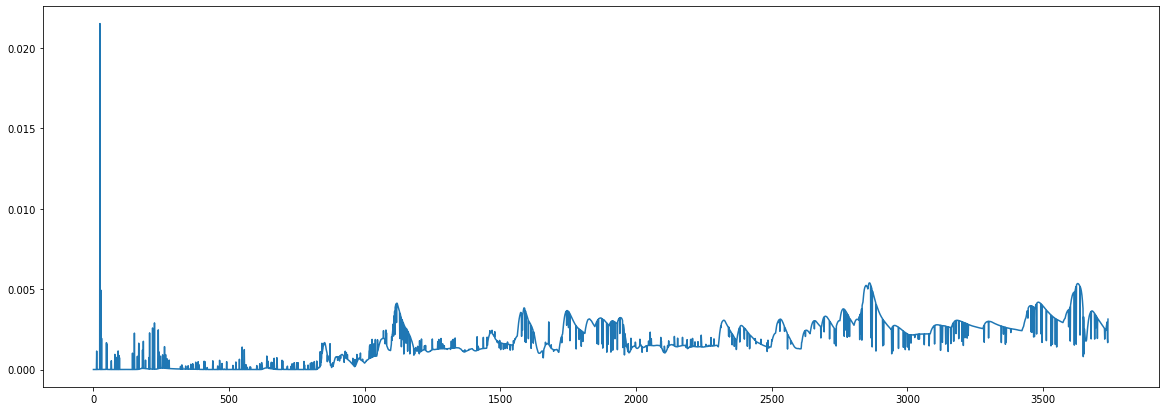

Finished episode  3750 / 5000  Total reward =  5.04
e =  3750  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  702256
e =  3760  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  704607
e =  3770  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  706982
Finished episode  3775 / 5000  Total reward =  5.08
e =  3780  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  709402
e =  3790  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  711995
Finished episode  3800 / 5000  Total reward =  5.2
e =  3800  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  714363
e =  3810  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  716699
e =  3820  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  719158
Finished episode  3825 / 5000  Total reward =  5.12
e =  3830  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  721555
e =  3840  eps =  0.009999999999999898  This reward =  6.0  Frame_cnt =  

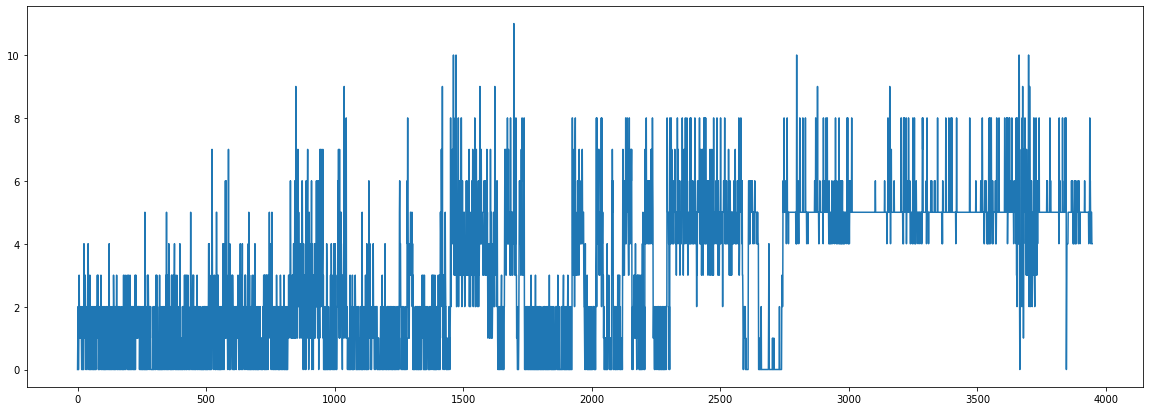

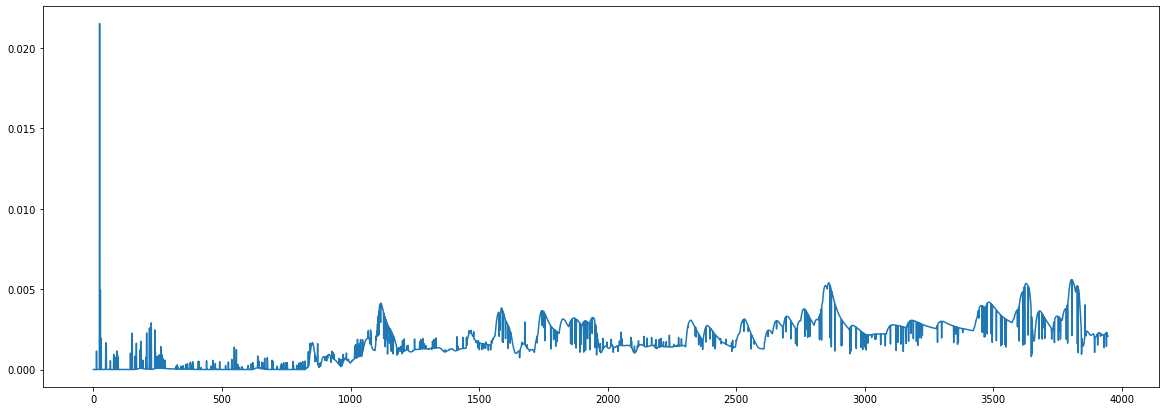

Finished episode  3950 / 5000  Total reward =  5.04
e =  3950  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  750465
e =  3960  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  752920
e =  3970  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  755564
Finished episode  3975 / 5000  Total reward =  5.52
e =  3980  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  758334
e =  3990  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  760800
Finished episode  4000 / 5000  Total reward =  5.16
Target model updated Successfully!
e =  4000  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  763255
e =  4010  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  766061
e =  4020  eps =  0.009999999999999898  This reward =  8.0  Frame_cnt =  768681
Finished episode  4025 / 5000  Total reward =  5.44
e =  4030  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  771535
e =  4040  eps =  0.00999999999999989

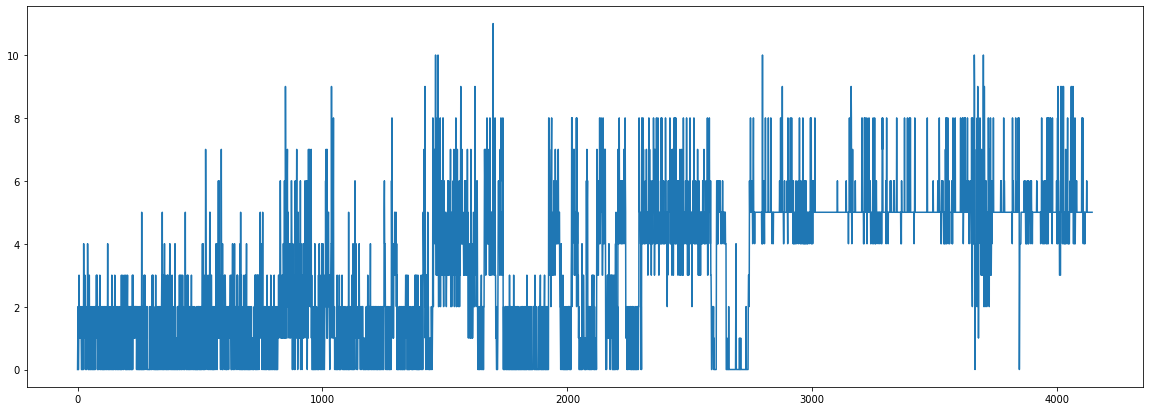

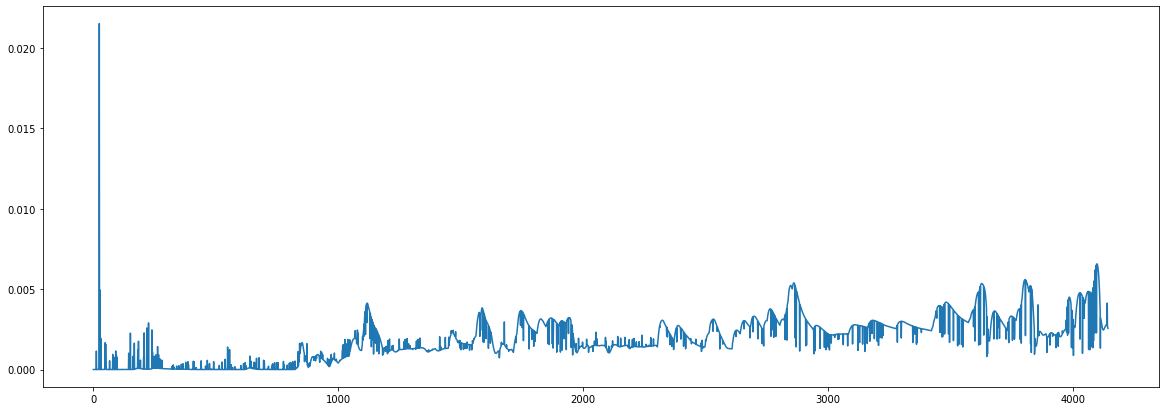

Finished episode  4150 / 5000  Total reward =  5.0
e =  4150  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  801331
e =  4160  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  803926
e =  4170  eps =  0.009999999999999898  This reward =  8.0  Frame_cnt =  806308
Finished episode  4175 / 5000  Total reward =  4.36
e =  4180  eps =  0.009999999999999898  This reward =  0.0  Frame_cnt =  807361
e =  4190  eps =  0.009999999999999898  This reward =  0.0  Frame_cnt =  808292
Finished episode  4200 / 5000  Total reward =  0.0
e =  4200  eps =  0.009999999999999898  This reward =  0.0  Frame_cnt =  809216
e =  4210  eps =  0.009999999999999898  This reward =  2.0  Frame_cnt =  810473
e =  4220  eps =  0.009999999999999898  This reward =  0.0  Frame_cnt =  811914
Finished episode  4225 / 5000  Total reward =  1.12
e =  4230  eps =  0.009999999999999898  This reward =  0.0  Frame_cnt =  812846
e =  4240  eps =  0.009999999999999898  This reward =  0.0  Frame_cnt =  8

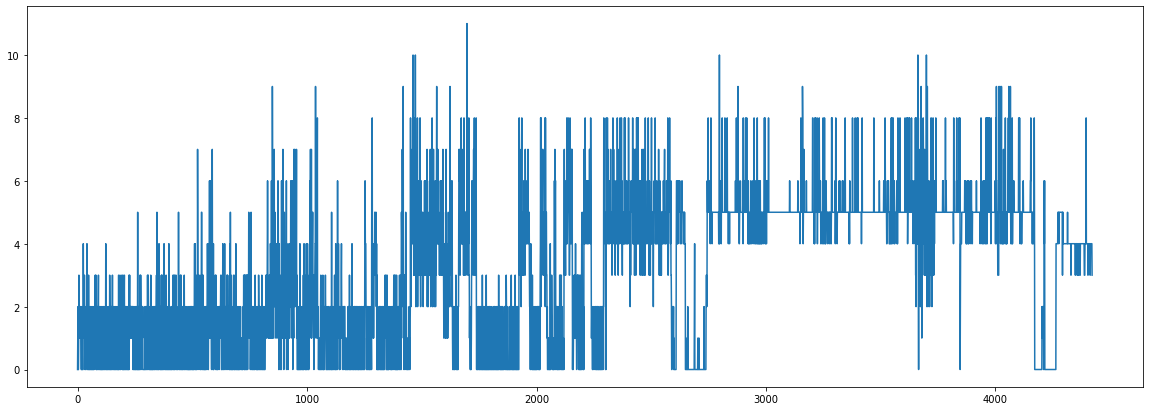

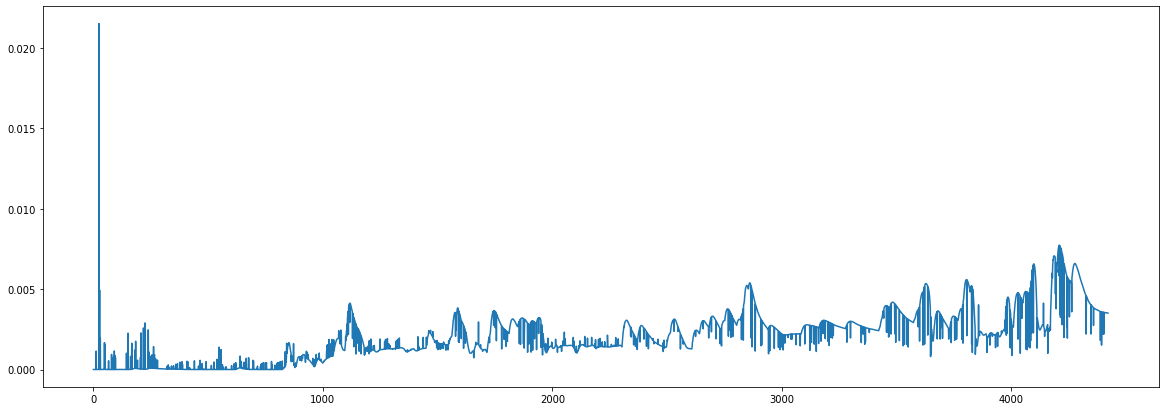

Finished episode  4425 / 5000  Total reward =  3.84
e =  4430  eps =  0.009999999999999898  This reward =  4.0  Frame_cnt =  851521
e =  4440  eps =  0.009999999999999898  This reward =  4.0  Frame_cnt =  853580
Finished episode  4450 / 5000  Total reward =  3.8
e =  4450  eps =  0.009999999999999898  This reward =  3.0  Frame_cnt =  855548
e =  4460  eps =  0.009999999999999898  This reward =  4.0  Frame_cnt =  857680
e =  4470  eps =  0.009999999999999898  This reward =  4.0  Frame_cnt =  859928
Finished episode  4475 / 5000  Total reward =  4.0
e =  4480  eps =  0.009999999999999898  This reward =  4.0  Frame_cnt =  861990
e =  4490  eps =  0.009999999999999898  This reward =  3.0  Frame_cnt =  863845
Finished episode  4500 / 5000  Total reward =  3.8
e =  4500  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  866036
e =  4510  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  868375
e =  4520  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  87

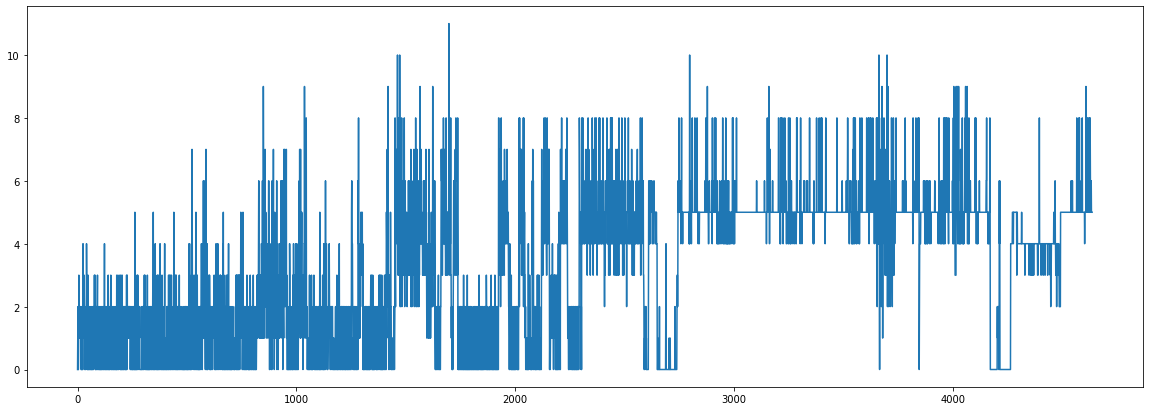

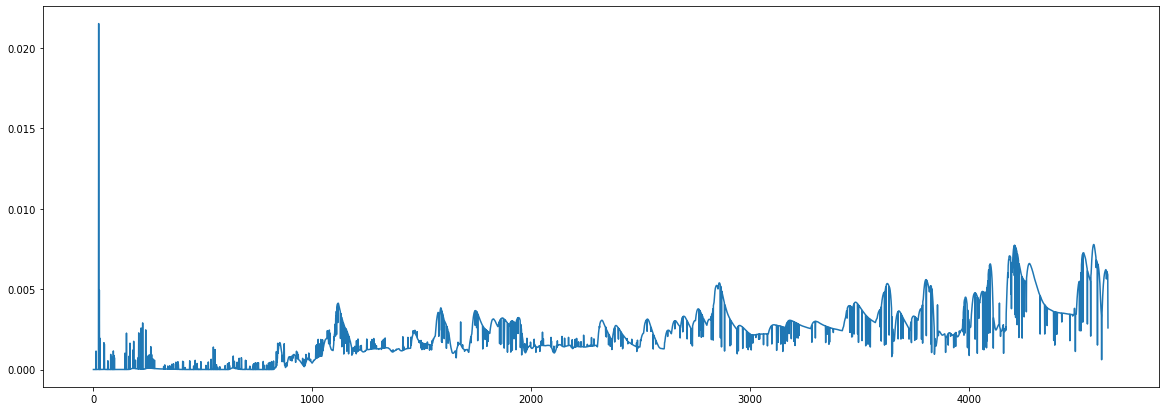

e =  4640  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  900700
Finished episode  4650 / 5000  Total reward =  5.44
e =  4650  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  903312
e =  4660  eps =  0.009999999999999898  This reward =  6.0  Frame_cnt =  905785
e =  4670  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  908147
Finished episode  4675 / 5000  Total reward =  5.2
e =  4680  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  910865
e =  4690  eps =  0.009999999999999898  This reward =  6.0  Frame_cnt =  913645
Finished episode  4700 / 5000  Total reward =  5.32
e =  4700  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  915952
e =  4710  eps =  0.009999999999999898  This reward =  8.0  Frame_cnt =  918550
e =  4720  eps =  0.009999999999999898  This reward =  3.0  Frame_cnt =  919564
Finished episode  4725 / 5000  Total reward =  3.08
e =  4730  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  

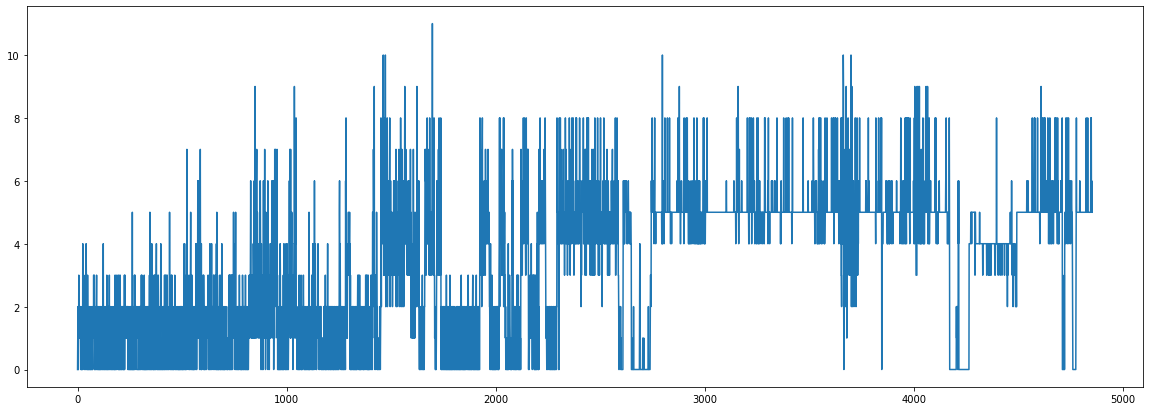

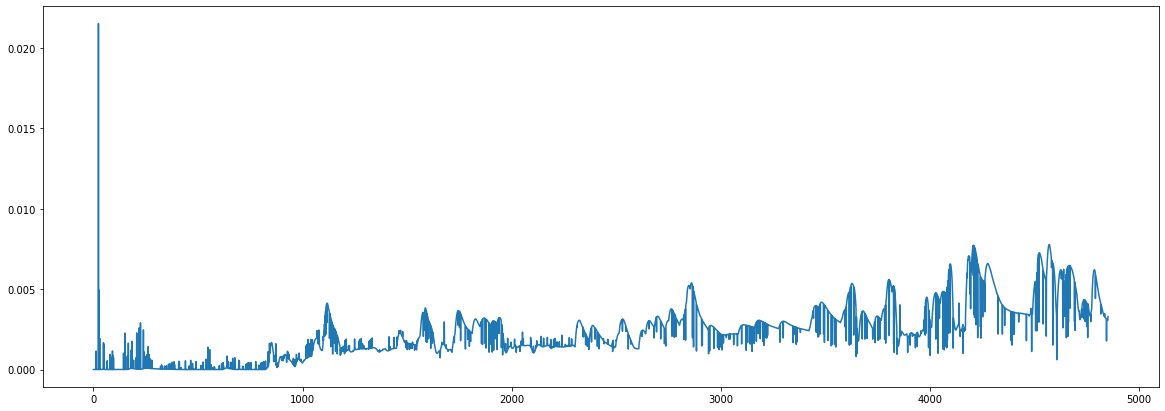

e =  4860  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  951389
e =  4870  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  953758
Finished episode  4875 / 5000  Total reward =  5.16
e =  4880  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  956369
e =  4890  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  958850
Finished episode  4900 / 5000  Total reward =  5.2
e =  4900  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  961331
e =  4910  eps =  0.009999999999999898  This reward =  0.0  Frame_cnt =  962966
e =  4920  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  965040
Finished episode  4925 / 5000  Total reward =  3.44
e =  4930  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  967390
e =  4940  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  969744
Finished episode  4950 / 5000  Total reward =  5.12
e =  4950  eps =  0.009999999999999898  This reward =  5.0  Frame_cnt =  

In [14]:
'''
TRAIN DQN ON THE GAME
'''
rew_list = []
for e in range(1, NUM_EPISODES+1):
    
    state = env.reset()
    #LAST LIVES = TOTAL NO OF LIVES REMAINING
    last_lives = 5
    terminal_life_lost = False 
    # FIRST ACTION IS ALWAYS 'FIRE' TO INITIATE THE GAME    
    state, _, _, _ = env.step(1)
    for _ in range(random.randint(1, 10)):
        #DOING RANDOM NO-OPs DURING START OF THE GAME TO STATE WITH A NEW STATE EVERY TIME
        state, _, _, _ = env.step(0)
    total_reward = 0
    processed_frame = preprocess(state)
    frames = []
    rgb_frames = []
    rgb_frames.append(state)

    for i in range(4):
        frames.append(processed_frame)

    state = np.stack(frames[-4:], axis = 2)

    diff = 0
    for itr in range(1, 20000):
        #select an action
        if(terminal_life_lost == True):
            state, _, _, _ = env.step(1)
            for _ in range(random.randint(1, NOOPMAX)):
                state, _, _, _ = env.step(0)
            processed_frame = preprocess(state)
            frames = []
            for i in range(4):
                frames.append(processed_frame)
            state = np.stack(frames[-4:], axis = 2)

        action = agent.next_action(state)
        FCNT = FCNT + 1

        #execute action
        next_state, reward, done, info = env.step(action)
        if info['ale.lives'] < last_lives:
            terminal_life_lost = True
        else:
            terminal_life_lost = done
        last_lives = info['ale.lives']

        if(e % 25 == 0):
            rgb_frames.append(next_state)
        
        #REWARD CLIPPING IS DONE
        if(reward > 0):
            reward = 1
        elif(reward < 0):
            reward = -1
        
        total_reward = total_reward + reward
        processed_frame = preprocess(next_state)
        processed_frame = processed_frame.astype(np.uint8)
        frames = frames[-3:]
        frames.append(processed_frame)
        next_state = np.stack(frames[-4:], axis = 2)

        #Store experience in replay mem
        agent.store_experience(state, action, reward, next_state, terminal_life_lost)
        #print(len(agent.memory.memory), itr)
        state = next_state
        
        
        if(FCNT % 50000 == 0):
            # SAVING CHECKPOINTS
            fname= "models/tmp_model_" + str(FCNT) + ".h5" 
            save_model(agent.model, fname)
            
            #plt.figure(figsize=(20,7))
            #plt.plot(REWARD_HISTORY)
            #plt.show()
            #plt.figure(figsize=(20,7))
            #plt.plot(LOSS_HISTORY)
            #plt.show()
           
            
        if done:
            REWARD_HISTORY.append(total_reward)
            rew_list.append(total_reward)
            
            if(e % 25 == 0):
                print("Finished episode ", e , "/", NUM_EPISODES, " Total reward = ", sum(rew_list)/len(rew_list))
                
                if not os.path.exists(VIS_DIR):
                    os.mkdir(VIS_DIR)
                generate_gif(len(rgb_frames), rgb_frames, sum(rew_list)/(len(rew_list)), VIS_DIR + "/", e)
                
                rew_list = []
            break

    # BACKPROP INITIATED AT THE END OF EVERY EPISODE AND NOT AT TGT_FREQ
    agent.replay(MINIBATCH_SIZE, filepath)
    filepath = filepath + 1
    if(e % 10 == 0):
        print("e = ", e, " eps = ", agent.epsilon, " This reward = ", total_reward, " Frame_cnt = ", FCNT)
    

save_model(agent.model, "models/" + MODEL_NAME)
print("Model Saved Successfully!! , Partyyyy")

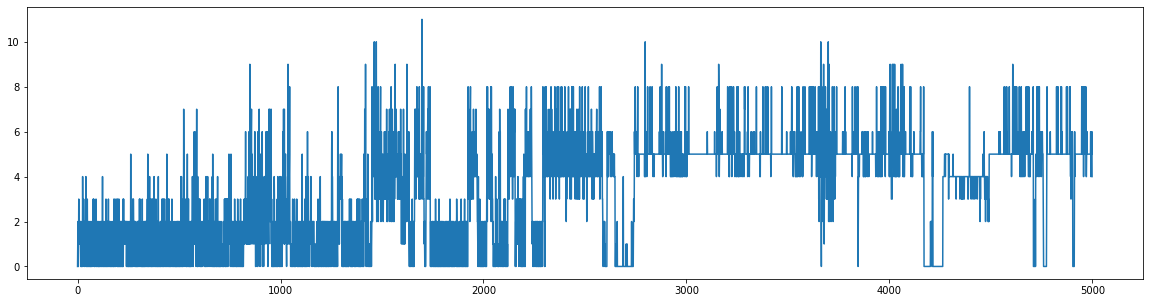

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(REWARD_HISTORY)
plt.show()

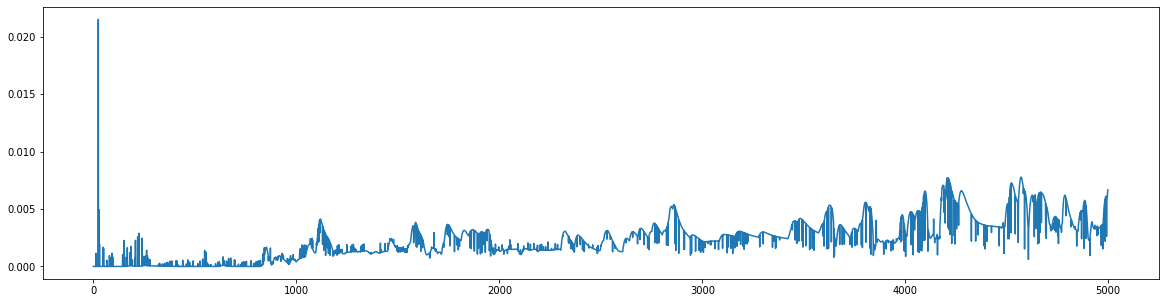

In [16]:
plt.figure(figsize=(20,5))
plt.plot(LOSS_HISTORY)
plt.show()

In [0]:
save_model(agent.model, "models/" + MODEL_NAME)

In [19]:
#########
#EVALUATE
#########
rew_list = []
for e in range(NUM_EVAL):
    state = env.reset()
    last_lives = 5
    terminal_life_lost = False 
    state, _, _, _ = env.step(1)
    for _ in range(random.randint(1, NOOPMAX)):
        state, _, _, _ = env.step(0)
    total_reward = 0
    processed_frame = preprocess(state)
    frames = []
    rgb_frames = []
    rgb_frames.append(state)
    for i in range(4):
        frames.append(processed_frame)
   
    state = np.stack(frames[-4:], axis = 2)

    diff = 0
    for itr in range(20000):
        #select an action
        if(terminal_life_lost == True):
            state, _, _, _ = env.step(1)
            for _ in range(random.randint(1, 10)):
                state, _, _, _ = env.step(0)
            processed_frame = preprocess(state)
            frames = []
            for i in range(4):
                frames.append(processed_frame)
            state = np.stack(frames[-4:], axis = 2)

        #action = agent.next_action(state)
        action = np.argmax(agent.model.predict([np.expand_dims(state,axis=0),agent.dummy_input])[0])
        FCNT = FCNT + 1
        #execute action
        next_state, reward, done, info = env.step(action)
        if info['ale.lives'] < last_lives:
            terminal_life_lost = True
        else:
            terminal_life_lost = done
        last_lives = info['ale.lives']
        rgb_frames.append(next_state)
       
        #REWARD CLIPPING IS DONE
        if(reward > 0):
            reward = 1
        elif(reward < 0):
            reward = -1
       
        total_reward = total_reward + reward
        processed_frame = preprocess(next_state)
        processed_frame = processed_frame.astype(np.uint8)
        frames = frames[-3:]
        frames.append(processed_frame)
        next_state = np.stack(frames[-4:], axis = 2)

        #Store experience in replay mem
        #agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            rew_list.append(total_reward)
            print("Finished episode ", e , "/", NUM_EVAL, " Total reward = ", total_reward)
            if not os.path.exists("test"):
                os.mkdir("test")
            generate_gif(len(rgb_frames), rgb_frames, total_reward, "test/", e)
            break


print("Testing Complete")


Finished episode  0 / 5000  Total reward =  4.0
Finished episode  1 / 5000  Total reward =  4.5
Finished episode  2 / 5000  Total reward =  4.333333333333333
Finished episode  3 / 5000  Total reward =  4.25
Finished episode  4 / 5000  Total reward =  4.4
Finished episode  5 / 5000  Total reward =  4.333333333333333
Finished episode  6 / 5000  Total reward =  4.285714285714286
Finished episode  7 / 5000  Total reward =  4.25
Finished episode  8 / 5000  Total reward =  4.222222222222222
Finished episode  9 / 5000  Total reward =  4.6
Finished episode  10 / 5000  Total reward =  4.909090909090909
Finished episode  11 / 5000  Total reward =  5.166666666666667
Finished episode  12 / 5000  Total reward =  5.076923076923077
Finished episode  13 / 5000  Total reward =  5.071428571428571
Finished episode  14 / 5000  Total reward =  5.066666666666666
Finished episode  15 / 5000  Total reward =  5.0625
Finished episode  16 / 5000  Total reward =  5.0
Finished episode  17 / 5000  Total reward =  5